# Interacting with NeuroMechFly

**Author:** Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will introduce the basic concepts of interacting with the simulated fly in a Markov Decision Process using the Gym interface. As a demonstration, we will replay experimentally recorded leg kinematics during walking in the simulator.

Markov Decision Process (MDP) and the Gym API
---------------------------------------------

We formulated the control of NeuroMechFly as a partially observable Markov Decision Process (MDP). At each time step, the simulation provides the controller with an observation and, optionally, a user-defined reward. Then, the simulation receives an action from the controller and steps the physics forward accordingly. The observation space is a user-configurable subset of the state space including visual inputs, olfactory inputs, ground contacts, joint states (angles, angular velocities, and torques), and the position and velocity of the fly model within the arena. The action space includes the control signal (e.g. angles for position control) for every actuated joint (e.g. 7 degrees-of-freedom (DoFs) per leg * 6 legs) and the on/off signal for leg adhesion. This framework is easily extendable: the user can incorporate additional layers of sensory preprocessing or premotor computation into the MDP.

| ![](https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true) | 
|:--:| 
| *The biomechanical model and its interaction with the environment are encapsulated as a MDP task. A user-defined controller interfaces with the task through actions (red) and observations (blue). The user can extend the MDP task by adding preprogrammed processing routines for motor outputs (purple) and sensory inputs (light blue), to modify the action and observation spaces handled by the controller.* |


Our implementation of the partially observable MDP complies with the [Gymnasium API](https://gymnasium.farama.org/). Gymnasium (a continuation of the now deprecated OpenAI Gym) is a package and standardized interface for developing and comparing control algorithms and benchmarking tasks. It provides a diverse collection of environments, ranging from classic control problems, Atari games, board games, and robotics simulations. Gym environments are designed to offer a common interface for controllers, in particular reinforcement learning agents, to interact with. This standardization makes it easier to develop and compare algorithms.

The overall steps for interacting with a Gym environment are:

1. Defining an environment
2. Reset the environment and get the initial observation
3. Interact with the environment with a loop:
   - Based on the last observation, the controller decides which actions to take
   - Step the simulation, applying the selected actions. The simulation will return you the new observation (and optionally some additional information)
   - Optional: render the simulation graphically
   - Break if certain conditions are met (e.g. task is accomplished or failed), otherwise continue

4. Close the environment and analyze the results

This process is illustrated in the following code snippet:

```Python
env = MyEnvironment(...)
obs, info = env.reset()

for step in range(1000):    # let's simulate 1000 steps max
    action = ...    # your controller decides what to do based on obs
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

env.close()
```

Note that the action can be selected by any means defined by the user (e.g. preprogrammed rules, algorithmic models, artificial neural networks).

### MDP specifications

Please refer to the `"MPD Task Specifications" page <https://neuromechfly.org/api_ref/mdp_specs.html#default-simulation>`_ of the API references for the detailed specifications of the action space, the observation space, the reward, the "terminated" and "truncated" flags, and the "info" dictionary.

## Example: Kinematic replay of experimentally recorded behavior

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Specifically, we recorded a tethered fly walking on an air-suspended spherical treadmill using seven zoomed-in cameras from different angles. We then estimated the 3D positions of keypoints on the joints using DeepFly3D (Günel et al., *Elife* 2019) and used inverse kinematics to calculate the angle at each DoF. With these we will use a PD controller to actuate the DoFs of the simulated fly at using these exact angles to see if the fly can walk untethered on flat terrain, as shown in the original NeuroMechFly paper (Lobato-Rios et al., *Nature Methods* 2022).

We start with the necessary imports:

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym import Fly, ZStabilizedCamera, SingleFlySimulation, get_data_path
from flygym.preprogrammed import all_leg_dofs

Let's define some simulation parameters:

In [2]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

We can now load recorded kinematics that are included with the FlyGym package:

In [3]:
data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

The dataset is provided at 2000 Hz. We will try to run the simulation at $\Delta t=0.0001s$ (10000 Hz), so let's interpolate it 5x:

In [4]:
target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

We can visualize the time series of DoF angles:

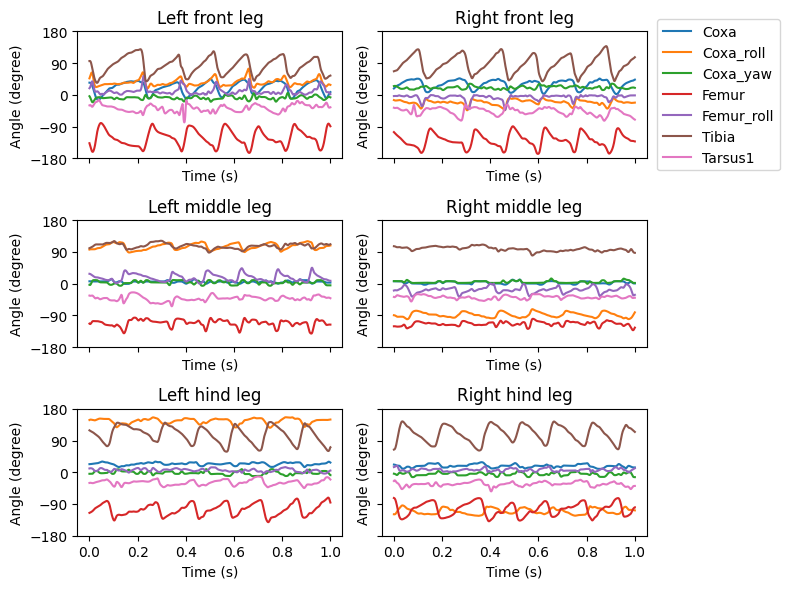

In [5]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.ravel()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

output_dir = Path("outputs/gym_basics/")
output_dir.mkdir(exist_ok=True, parents=True)
fig.savefig(output_dir / "kin_replay_joint_dof_time_series.png")

Now we can create a NeuroMechFly simulation instance and play out the recorded kinematics in the MDP loop:

In [6]:
fly = Fly(init_pose="stretch", actuated_joints=actuated_joints, control="position")
cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody, camera_name="camera_left", attachment_name=fly.name,
    targeted_fly_names=[fly.name], play_speed=0.1
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()
for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

100%|██████████| 10000/10000 [00:49<00:00, 200.97it/s]


To save the rendered video:

In [7]:
cam.save_video(output_dir / "kinematic_replay.mp4")

<video src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/gym_basics/kinematic_replay.mp4" controls="controls" style="max-width: 730px;"></video>

We can inspect the observation at the last step to see if they are consistent with our expectations:

In [8]:
for k, v in obs.items():
    print(f"{k}: shape {v.shape}")

joints: shape (3, 42)
fly: shape (4, 3)
contact_forces: shape (30, 3)
end_effectors: shape (6, 3)
fly_orientation: shape (3,)
cardinal_vectors: shape (3, 3)


The basic NeuroMechFly simulation always returns 0 as the reward. It always returns False for the `terminated` and `truncated` flags. The `info` is also empty. The user can extend the `NeuroMechFly` class to modify these behaviors.

In [9]:
print(f"reward: {reward}")
print(f"terminated: {terminated}")
print(f"truncated: {truncated}")
print(f"info: {info}")

reward: 0
terminated: False
truncated: False
info: {'flip': False}
